In [1]:
import pysam, subprocess
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.signal import find_peaks
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('paper_style.mplstyle')

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

# Peak Plot & Table

In [2]:
def fragdensity(path_to_bam, min_mapq=0, refseq_index=0, dtype=np.uint32):
    def filterReads(reads):
        for read in reads:  # yield only reads which are proper paired, meet mapq cutoff, and are one side of the fragment
            if read.is_proper_pair and read.mapping_quality >= min_mapq and read.template_length > 0:
                yield read
    # prepare the output array and load the experiment
    bam = pysam.Samfile(path_to_bam, "rb")  # load the bam file
    density_array = np.zeros((bam.lengths[refseq_index],), dtype)
    fragment_lengths = []
    # load and filter the reads and add them to the density array
    filtered_reads = filterReads(bam.fetch(bam.references[refseq_index]))
    n_mapped = 0
    for read in filtered_reads:
        # add a count for the left side of the fragment
        density_array[read.pos:read.pos + read.template_length] += 1
        # record the length of the fragment
        fragment_lengths.append(read.template_length)
        # record number of reads
        n_mapped += 1 
    # return density array and numpy array of fragment lengths
    return density_array, n_mapped, np.asarray(fragment_lengths)


def countnormalization_1d(sample_arrays, counts):
    # load arrays
    sample_arrays = np.asarray(sample_arrays)
    counts = np.asarray(counts)
    size_factors = counts / gmean(counts)
    # now normalize the arrays
    normalized_sample_arrays = (sample_arrays + 1) / size_factors.reshape(-1, 1)
    return normalized_sample_arrays


def decimatedata(x, y, function, steps):
    step_pairs = np.asarray(
        [np.linspace(min(x), max(x), num=steps)[:-1],
         np.linspace(min(x), max(x), num=steps)[1:]]).T
    new_x = []
    new_y = []
    for pair in step_pairs:
        new_x.append(np.mean(pair))
        new_y.append(function(y[np.all([x >= pair[0], x < pair[1]], axis=0)]))
    return np.asarray(new_x), np.asarray(new_y)

def linePlot(x, y, axis, **kwargs):
    min_y = min(y)
    for x_pt, y_pt in zip(x, y):
        axis.plot([x_pt, x_pt], [min_y, y_pt], **kwargs)

def nearbygenes(bp_position, gene_table, n_genes_per_side=1):
    # first, check if we're in a gene already
    try:
        intergenic = gene_table.loc[
            gene_table.index[np.all([gene_table.start <= bp_position, gene_table.end >= bp_position], axis=0)].values,'plt_tag'].values[0]
    except:
        intergenic = 'None'
    # pull from the left side
    try:
        left = gene_table.loc[gene_table.end < bp_position,'plt_tag'][-1*n_genes_per_side:].values[0]
    except:
        left = 'None'
    # pull from the right side
    try:
        right = gene_table.loc[gene_table.start > bp_position,'plt_tag'][:n_genes_per_side].values[0]
    except:
        right = 'None'
    return left, intergenic, right

Count normalize and place samples in a dictionary by name.

In [3]:
bam_inputs = {
    's1_0nM': 'idapseq/bams/s1_0nM.bam',
    's2_0nM': 'idapseq/bams/s2_0nM.bam',
    's3_300nM': 'idapseq/bams/s3_300nM.bam',
    's4_300nM': 'idapseq/bams/s4_300nM.bam'}


# load gene table
gene_table = pd.read_csv(
    'datasets/gt_mtb_h37rv.csv', index_col=0)

In [4]:
sample_arrays = []
counts = [] 
for name, bam_path in bam_inputs.items():
    density_array, n_mapped, _ = fragdensity(bam_path)
    sample_arrays.append(density_array)
    counts.append(n_mapped)
normalized_counts = countnormalization_1d(sample_arrays, counts)
count_dict = {
    name: normalized_counts[i] for i, name in enumerate(bam_inputs.keys())}

# get average binding signal
binding_signal = (
    np.mean([count_dict['s3_300nM'], count_dict['s4_300nM']], axis=0) /
    np.mean([count_dict['s1_0nM'], count_dict['s2_0nM']], axis=0))

# identify top 50 peaks
indexes = find_peaks(binding_signal, distance=500)[0]
top_peaks = pd.DataFrame(
    data=binding_signal[indexes],
    columns=['signal'],
    index=indexes).sort_values('signal', ascending=False).head(50)

# get nearby genes
nearby_genes = pd.DataFrame(
    data=np.asarray([nearbygenes(idx, gene_table) for idx in top_peaks.index]),
    index=top_peaks.index[:50],
    columns=['left', 'intergenic', 'right'])
nearby_genes.left = nearby_genes.left.str.replace('\n', ' ')
nearby_genes.intergenic = nearby_genes.intergenic.str.replace('\n', ' ')
nearby_genes.right = nearby_genes.right.str.replace('\n', ' ')

# concatenate the dataframes
top_peaks = pd.concat([top_peaks, nearby_genes], axis=1)
top_peaks.to_csv('outputs/tables/TableS4_slfR_binding_peaks.csv')

In [10]:
pd.DataFrame(
    data=[count_dict['s1_0nM'], count_dict['s2_0nM'], count_dict['s3_300nM'], count_dict['s4_300nM'], binding_signal],
    index=['s1_0nM', 's2_0nM', 's3_300nM', 's4_300nM', 'binding_signal']).T.to_csv('idapseq/Rv0042c_signal.csv.gz', index=False)

Plot of top peaks.

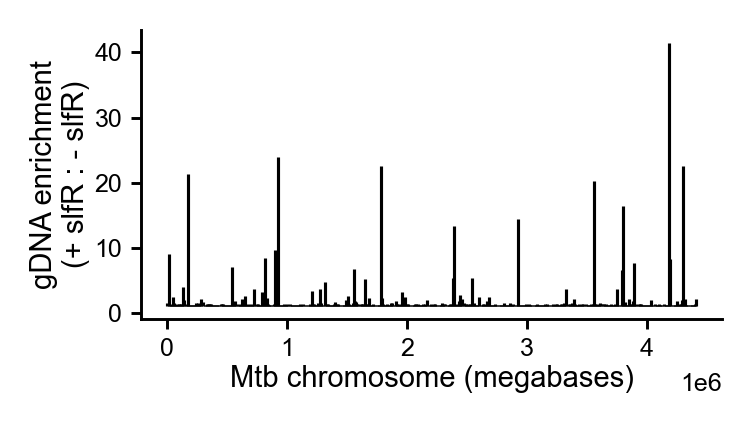

In [10]:
output_dir = 'outputs/figures'
output_name = '4C_slfR_binding_peaks.pdf'
decimation_n = 500

fig, ax = plt.subplots(
    1, 1, figsize=(2.5, 1.25))

dec_x, dec_signal = decimatedata(
    np.arange(len(binding_signal)), binding_signal, np.max, decimation_n)
linePlot(dec_x, dec_signal, ax, lw=0.75, c='k', solid_capstyle='butt')
ax.set_ylabel('gDNA enrichment\n(+ slfR : - slfR)')
ax.set_xlabel('Mtb chromosome (megabases)')
sns.despine()

plt.savefig(
    f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

# Binding Motif

In [18]:
# load in peak table
top_peaks = pd.read_csv(
    'outputs/tables/TableS4_slfR_binding_peaks.csv', index_col=0)

In [19]:
genome_path = 'datasets/Mtb_h37rv.fasta'
meme_path = '/Users/pculviner/meme/bin/meme'
half_width = 100
threshold = 5


genome_seq = SeqIO.read(
    genome_path,
    format='fasta').seq

with open('tmp/meme_input.txt', 'w') as f:
    for idx in top_peaks.index[top_peaks.signal > threshold]:
        window = genome_seq[idx - half_width:idx + half_width + 1]
        f.write(f'>peak{idx}\n{window}\n')

subprocess.run(
    f'{meme_path} -dna -mod zoops -nmotifs 3 -revcomp -pal -oc outputs/figures/S4A_slfR_meme_outputs tmp/meme_input.txt',
    shell=True)

Writing results to output directory 'outputs/figures/S4A_slfR_meme_outputs'.
BACKGROUND: using background model of order 0
PRIMARY (classic): n 18 p0 18 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 3618 highwater mark: seq 18 pos 193
Initializing the motif probability tables for 4 to 36 sites...
nsites = 36
Done initializing.

seqs=    18, min_w= 201, max_w=  201, total_size=     3618

motif=1
SEED DEPTHS: 2 4 8 16 18
SEED WIDTHS: 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  18, iter=  10 Warning: Cannot convert EPS file to PNG as no install of Image Magick or Ghostscript is usable.

motif=2
SEED DEPTHS: 2 4 8 16 18
SEED WIDTHS: 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  18, iter=  20 Warning: Cannot convert EPS file to PNG as no install of Image Magick or Ghostscript is usable.

motif=3
SEED DEPTHS: 2 4 8 16 18
SEED WIDTHS: 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  18, iter= 

CompletedProcess(args='/Users/pculviner/meme/bin/meme -dna -mod zoops -nmotifs 3 -revcomp -pal -oc outputs/figures/S4A_slfR_meme_outputs tmp/meme_input.txt', returncode=0)

# Convert Proteomics Data to Rv indexes

Load and mask proteomics data

In [21]:
proteomics_data = pd.read_csv(
    f'datasets/240816_protein_pellets_42c.csv',
    header=[0, 1, 2, 3, 4], index_col=[0, 1])

# mask duplicate genes
gene, count = np.unique(
    proteomics_data.index.get_level_values('Genes'),
    return_counts=True)
duplicate_mask = np.isin(
    proteomics_data.index.get_level_values('Genes'), gene[count != 1])

# mask ambiguous genes
ambiguous_mask = proteomics_data.index.get_level_values(
    'Protein.Ids').str.count(';') != 0

# mask genes that don't exist in all samples
missing_mask = np.any(
    np.isnan(proteomics_data), axis=1)

# apply above filters
proteomics_filtered = proteomics_data.loc[
    ~np.any([duplicate_mask, ambiguous_mask, missing_mask], axis=0)]

Run Rv crossref to get Rv numbers

In [24]:
rv_xref = pd.read_csv(
    'datasets/Rv_NCBI_Uniprot.validated.xref.csv', index_col='UniprotID')

is_keep = []
new_index = []
i = 0
for protein_id in proteomics_filtered.index.get_level_values('Protein.Ids'):
    i += 1
    try:
        rv_ids = rv_xref.loc[[protein_id], 'RvGeneID']
    except KeyError:
        print('Not found:', protein_id)
        is_keep.append(False)
        continue
    if len(np.unique(rv_ids)) == 1:
        new_index.append(np.unique(rv_ids)[0])
        is_keep.append(True)
    else:
        print('Multiple Rvs:', protein_id)
        is_keep.append(False)

proteomics_rv = proteomics_filtered.loc[is_keep]
proteomics_rv.index = pd.Index(new_index, name='geneid')
proteomics_rv.to_csv(f'datasets/240816_protein_pellets_42c.filtered.csv')

Multiple Rvs: A0A089QRB9
Not found: I6WXS6
Not found: L0T6I4
Not found: L0TBP1
Not found: L0TBY6
Not found: O05878
Not found: O07744
Not found: O07788
Not found: O53915
Not found: O53916
Not found: P0DMQ8
Not found: P71834
Not found: P71835
Not found: P96397
Not found: P9WH15
Multiple Rvs: P9WHF9
Not found: P9WIT1
Not found: P9WKH5
Not found: P9WL99
Not found: Q79FG9
Not found: V5QPS4


# Run Proteomics Z-test

In [42]:
prot_df = np.log2(pd.read_csv(
    f'datasets/240816_protein_pellets_42c.filtered.csv',
    header=[0, 1, 2, 3, 4], index_col=[0]))

In [43]:
# get replicate means
prot_replicate_means = prot_df.T.groupby(by=['genotype', 'pair']).mean()

# get group deltas
prot_group_deltas = pd.DataFrame(
    data=prot_replicate_means.loc[
            pd.IndexSlice['MUT', :], :].values - 
         prot_replicate_means.loc[
            pd.IndexSlice['WT', :], :].values,
    columns=prot_replicate_means.columns,
    index=['A', 'B', 'C']).T

# get mean deltas
prot_mean_deltas = prot_group_deltas.mean(1)

# get z-scores
values_0 = prot_replicate_means.loc[
    pd.IndexSlice['MUT', :], :].values
values_1 = prot_replicate_means.loc[
    pd.IndexSlice['WT', :], :].values
prot_ztest = pd.DataFrame(
    columns=prot_df.index,
    index=['zscore', 'pvalue'],
    data=ztest(values_0, values_1, usevar='unequal')).T
prot_ztest.loc[:, 'fdr_bh_pvalue'] = multipletests(
    prot_ztest.pvalue, method='fdr_bh', alpha=0.05)[1]
prot_ztest.loc[:, 'mean_delta'] = prot_mean_deltas
prot_ztest.sort_values('fdr_bh_pvalue', ascending=True).to_csv('outputs/tables/TableS5_proteomics_ztest.csv')

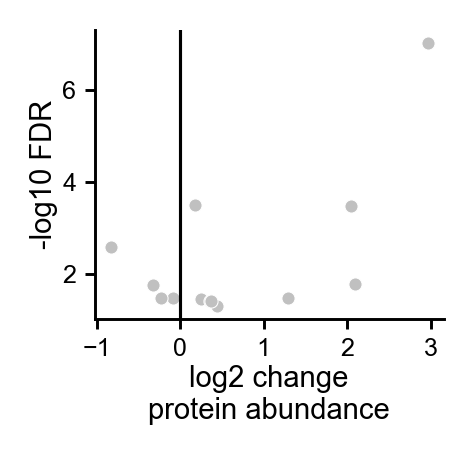

In [44]:
output_dir = 'outputs/figures'
output_name = '4D_slfR_proteomics.pdf'

# keep only those meeting 0.05 FDR
plot_df = prot_ztest.copy()
plot_df.loc[:, '-log10 alpha'] = -np.log10(plot_df.loc[:, 'fdr_bh_pvalue'])
plot_df = plot_df.loc[plot_df.loc[:, 'fdr_bh_pvalue'] < 0.05]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.25))

sns.scatterplot(
    data=plot_df,
    y='-log10 alpha',
    x='mean_delta',
    color=colors['gray'],
    s=10,
    legend=False)
ax.axvline(
    0, 0, 1, lw=0.75, color='k')
# ax.set_yticks(
#     [5, 10, 15, 20])
ax.set_xticks(
    [-1, 0, 1, 2, 3])
ax.set_xlabel('log2 change\nprotein abundance')
ax.set_ylabel('-log10 FDR')
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

# Compare Proteomics & RNA-Seq

In [2]:
# load abundance data
prot_df = np.log2(pd.read_csv(
    f'datasets/240816_protein_pellets_42c.filtered.csv',
    header=[0, 1, 2, 3, 4], index_col=[0]))

# get replicate means
prot_replicate_means = prot_df.T.groupby(by=['genotype', 'pair']).mean()

# get group deltas
prot_group_deltas = pd.DataFrame(
    data=prot_replicate_means.loc[
            pd.IndexSlice['MUT', :], :].values - 
         prot_replicate_means.loc[
            pd.IndexSlice['WT', :], :].values,
    columns=prot_replicate_means.columns,
    index=['A', 'B', 'C']).T

# get mean deltas
prot_mean_deltas = prot_group_deltas.mean(1)

In [5]:
# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)

rna_df = exp_df.loc[
    :, pd.IndexSlice[:, ['g2g_030', 'vci_269', 'vci_246', 'vci_089', 'vci_569', 'vci_035'], :]]
# convert to same labeling scheme as proteins
rna_df.columns = prot_df.columns

# get replicate means
rna_replicate_means = rna_df.T.groupby(by=['genotype', 'pair']).mean()

# get group deltas
rna_group_deltas = pd.DataFrame(
    data=rna_replicate_means.loc[pd.IndexSlice['MUT', :], :].values - rna_replicate_means.loc[pd.IndexSlice['WT', :], :].values,
    columns=rna_replicate_means.columns,
    index=['A', 'B', 'C']).T

# get mean deltas
rna_mean_deltas = rna_group_deltas.mean(1)

In [9]:
target_geneids = ['Rv0830', 'Rv3825c', 'Rv3824c', 'Rv3823c']

# protein bar graph dataframe
prot_bar_df = pd.DataFrame(
    data=[
        target_geneids,
        prot_mean_deltas.loc[target_geneids]],
    index=['gene', 'mean']).T
prot_bar_df.loc[:, 'data'] = 'protein'

prot_scatter_df = prot_group_deltas.loc[target_geneids].melt(ignore_index=False).reset_index()
prot_scatter_df.loc[:, 'data'] = 'protein'
prot_scatter_df.columns = ['gene', 'variable', 'value', 'data']

# rna bar graph dataframe
rna_bar_df = pd.DataFrame(
    data=[
        target_geneids,
        rna_mean_deltas.loc[target_geneids]],
    index=['gene', 'mean']).T
rna_bar_df.loc[:, 'data'] = 'rna'

rna_scatter_df = rna_group_deltas.loc[target_geneids].melt(ignore_index=False).reset_index()
rna_scatter_df.loc[:, 'data'] = 'rna'
rna_scatter_df.columns = ['gene', 'variable', 'value', 'data']

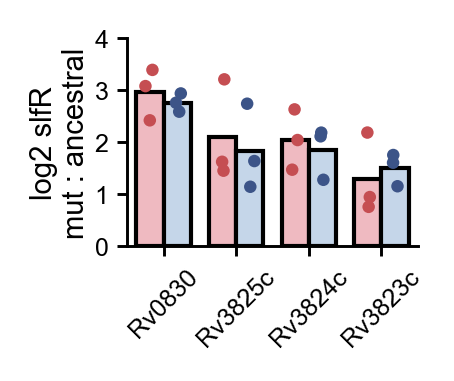

In [14]:
output_dir = 'outputs/figures'
output_name = '4E_rna_vs_proteomics.pdf'

fig, ax = plt.subplots(figsize=(1.25, 0.9))

sns.barplot(
    ax=ax,
    data=pd.concat([prot_bar_df, rna_bar_df], axis=0),
    hue='data',
    width=0.75,
    lw=1,
    edgecolor='k',
    y='mean',
    x='gene',
    palette={'protein': colors['lred'], 'rna': colors['lblue']},
    orient='x',
    legend=False)

sns.stripplot(
    ax=ax,
    hue='data',
    data=pd.concat([prot_scatter_df, rna_scatter_df], axis=0),
    dodge=True,
    y='value',
    x='gene',
    palette={'protein': colors['dred'], 'rna': colors['dblue']},
    size=3,
    legend=False)

ax.set_ylabel('log2 slfR\nmut : ancestral')
ax.set_xlabel('')


plt.xticks(rotation=45)
ax.set_yticks([0, 1, 2, 3, 4])
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=400)